In [1]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

import SimpleITK as stk
import cell_magic_wand as cmw

In [2]:
root = "../DATA/subset0/"
output_path = "../Processed/nodule_mask/"

In [3]:
def load_mhd(file):
    mhdimage = stk.ReadImage(root+file)
    ct_scan = stk.GetArrayFromImage(mhdimage)    # indexes are z,y,x
    origin = np.array(mhdimage.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    space = np.array(mhdimage.GetSpacing())      # spacing of voxels in world coor. (mm)
    return ct_scan, origin, space

In [4]:
######### Test CT-Scans ########
test1 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd"
test2 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd"
test3 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd"
test4 = "1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd"

tests = [test1, test2, test3, test4]

In [5]:
###### Test ######
for i,test in enumerate(tests):
    exec(f"ct{i+1}, origin{i+1}, space{i+1} = load_mhd(test)")

print("CT_SCAN SHAPE:",ct4.shape)
print("Origin:",origin4)
print("Space:",space4)
print("MAX:",ct4.max())
print("MIN:",ct4.min())

CT_SCAN SHAPE: (588, 512, 512)
Origin: [-157.24316406 -281.24316406 -336.        ]
Space: [0.51367188 0.51367188 0.5       ]
MAX: 3071
MIN: -1024


In [6]:
test_imgs = [ct1, ct2, ct3, ct4]
origins = [origin1, origin2, origin3, origin4]
spaces = [space1, space2, space3, space4]

In [7]:
def display(imgs, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//4 if n%4==0 else (n//4)+1
    plt.figure(figsize=(25,14))
    for i,img in enumerate(imgs):
        plt.subplot(r,4,i+1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img, cmap=cmap)

In [8]:
def display_mask(imgs, masks, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//2 if n%2==0 else (n//2)+1
    plt.figure(figsize=(20,40))
    for i,(img, mask) in enumerate(zip(imgs,masks)):
        plt.subplot(r,2,i+1)
        ig = np.hstack((img, mask))
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(ig, cmap=cmap)

In [9]:
annotations = pd.read_csv("../DATA/annotations.csv")

In [10]:
def make_mask(center, diam, z, width, height, spacing, origin):
    '''
    Params:-
    Center : centers of circles px -- list of coordinates x,y,z
    diam : diameters of circles px -- diameter
    widthXheight : pixel dim of image
    spacing = mm/px conversion rate np array x,y,z
    origin = x,y,z mm np.array
    z = z position of slice in world coordinates mm
    '''
    mask = np.zeros([height,width])  # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5]) 
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 255.0
    return mask

In [11]:
def make_mask2(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.circle(mask, (int(center[0]),int(center[1])), diam//2, 255, -1)
    return mask

In [42]:
masks = []
imgs = []
tt = -1
v_centers = []
v_diameters = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
for i, (img, filename, origin, spacing) in enumerate(zip(test_imgs, tests, origins, spaces)):
    width = img.shape[2]
    height = img.shape[1]
    sid = filename.replace(".mhd","")
    nodule_df = annotations[annotations["seriesuid"]==sid]
#     img_base = np.zeros((height, width))
    p_vcenter = None
    tt += 1
    for i, mask_i in nodule_df.iterrows():
        node_x = int(mask_i["coordX"])
        node_y = int(mask_i["coordY"])
        node_z = int(mask_i["coordZ"])
        diam = int(mask_i["diameter_mm"])
        
        center = np.array([node_x, node_y, node_z])   # nodule center
        v_center = np.rint((center-origin)/spacing)   # nodule center in voxel space (still x,y,z ordering)
        v_diam = int(diam/spacing[0])+5
        print(v_center)
        # mask = make_mask(center, diam, v_center[2]*spacing[2]+origin[2], width, height, spacing, origin)
        img_norm = cv2.normalize(img[int(v_center[2]),:,:], None, 0, 255, cv2.NORM_MINMAX)
        
        ##########################################################################################
        mask = make_mask2(img_norm, v_center, v_diam)
        print(v_diam)
        if v_diam>18:
            img_norm2 = cv2.normalize(img[(int(v_center[2])-1),:,:], None, 0, 255, cv2.NORM_MINMAX)
            mask2 = make_mask2(img_norm2, v_center, v_diam-1)
            img_norm3 = cv2.normalize(img[(int(v_center[2])+1),:,:], None, 0, 255, cv2.NORM_MINMAX)
            mask3 = make_mask2(img_norm3, v_center, v_diam-1)
            img_norm2 = clahe.apply(img_norm2.astype(np.uint8))
            img_norm3 = clahe.apply(img_norm3.astype(np.uint8))
            masks.append(mask2)
            masks.append(mask3)
            imgs.append(img_norm2)
            imgs.append(img_norm3)
            v_centers.append(list(v_center))
            v_centers.append(list(v_center))
            v_diameters.append(v_diam)
            v_diameters.append(v_diam)
        ##########################################################################################
        
        img_norm = clahe.apply(img_norm.astype(np.uint8))
        #############################################
        # mask = cmw.cell_magic_wand(img_norm, [v_center[0], v_center[1]], 2, diam+2).T
        #############################################
        
        masks.append(mask)
        imgs.append(img_norm)
        v_centers.append(list(v_center))
        v_diameters.append(v_diam)
#     masks.append(mask_base)
        

[111. 346.  33.]
13
[322. 381. 101.]
19
[ 83. 307.  92.]
19
[114. 348.  90.]
27
[ 96. 205. 288.]
20


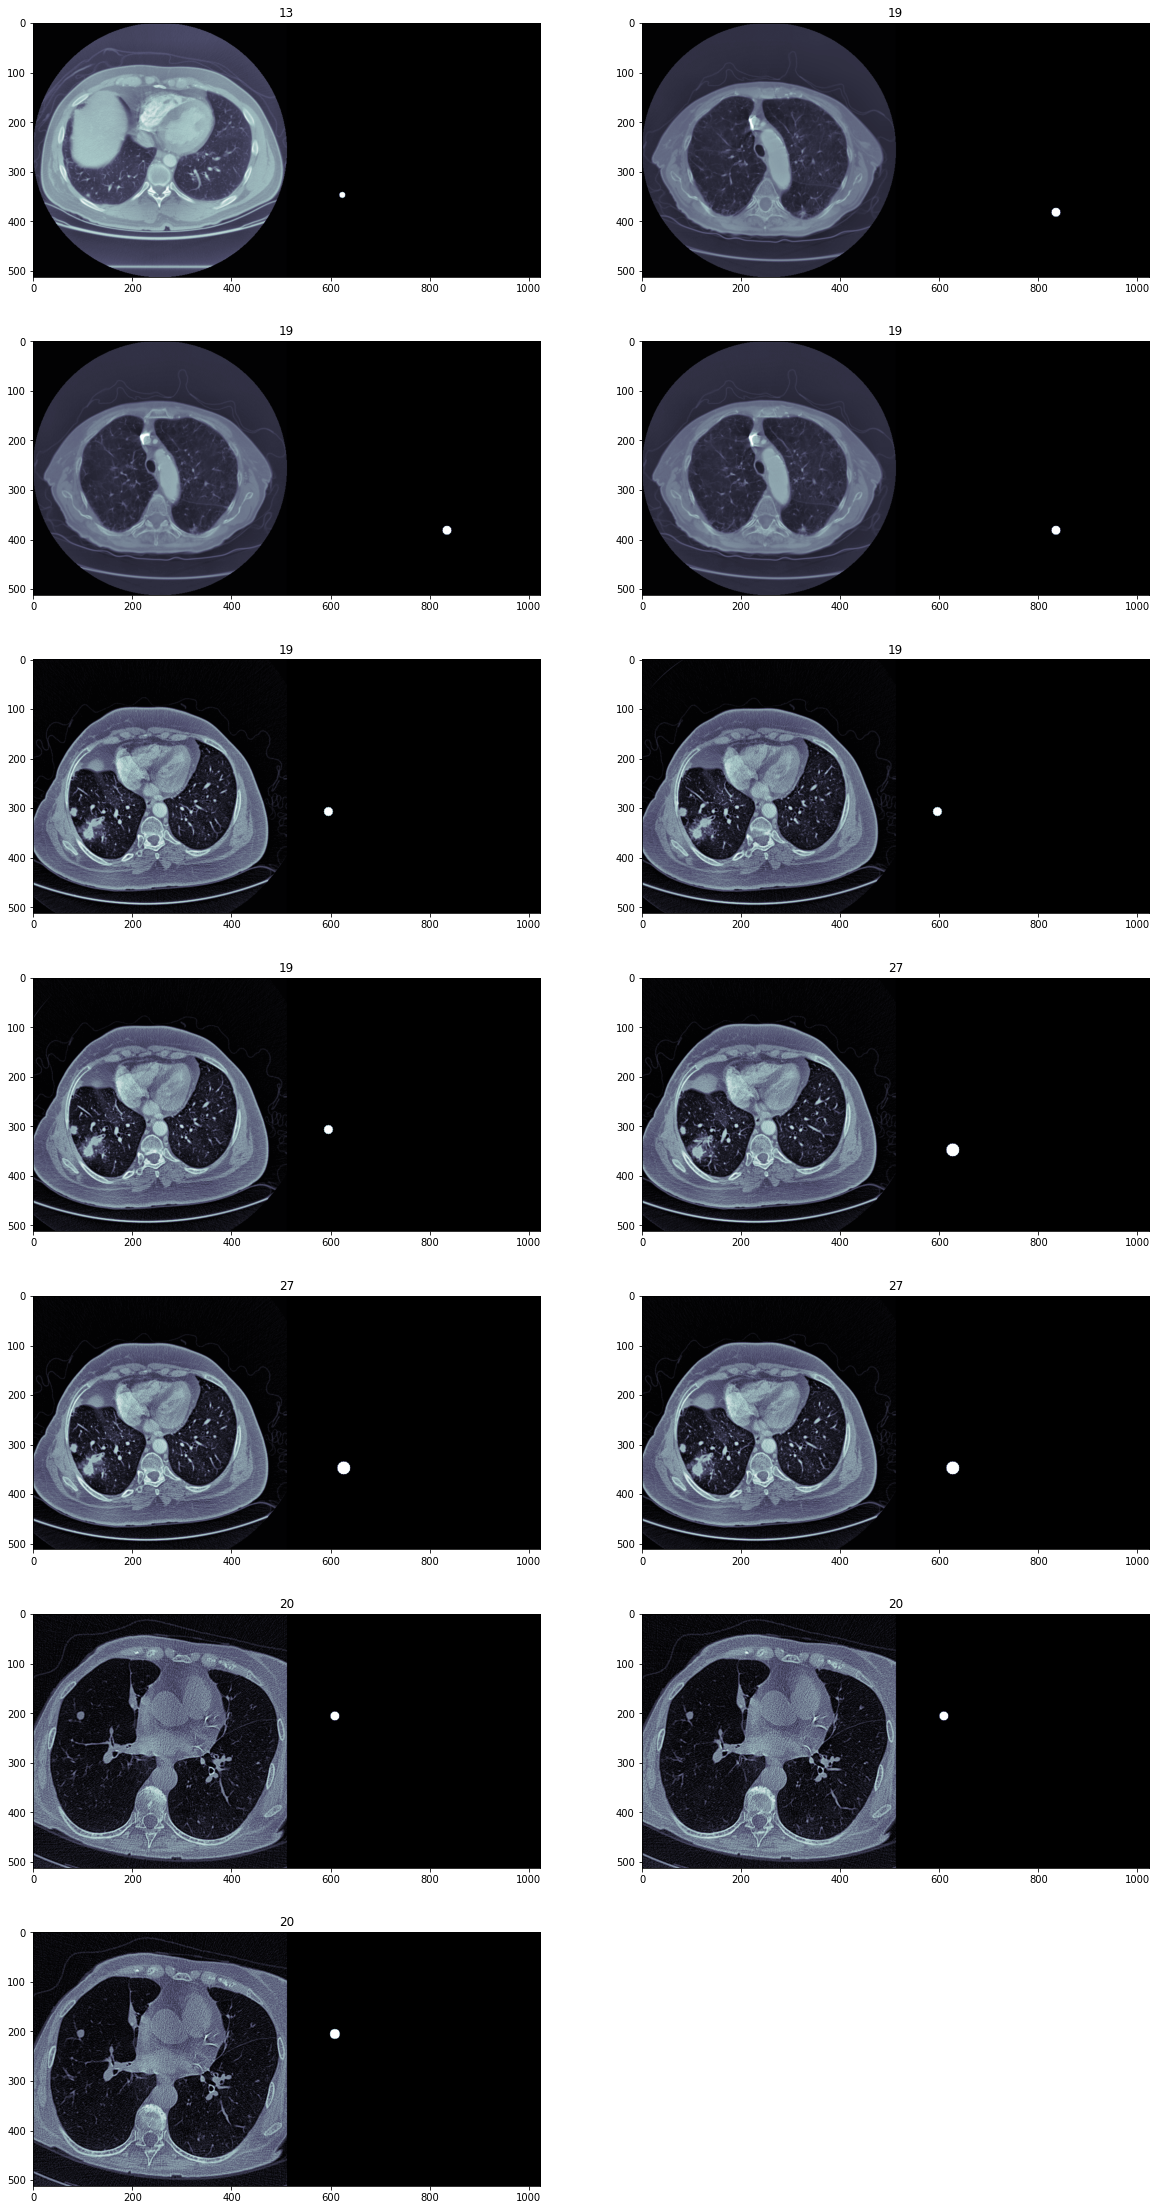

In [43]:
display_mask(imgs, masks, titles=v_diameters)

In [53]:
masksi = []
from sklearn.cluster import KMeans
for i,m in zip(imgs,masks):
    centeral_area = i[100:400, 100:400]
    kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
    centroids = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centroids)
    mk = cv2.bitwise_and(i, i, mask=m)
    ret, lung_nod = cv2.threshold(mk, threshold-5, 255, cv2.THRESH_BINARY)
    masksi.append(lung_nod)

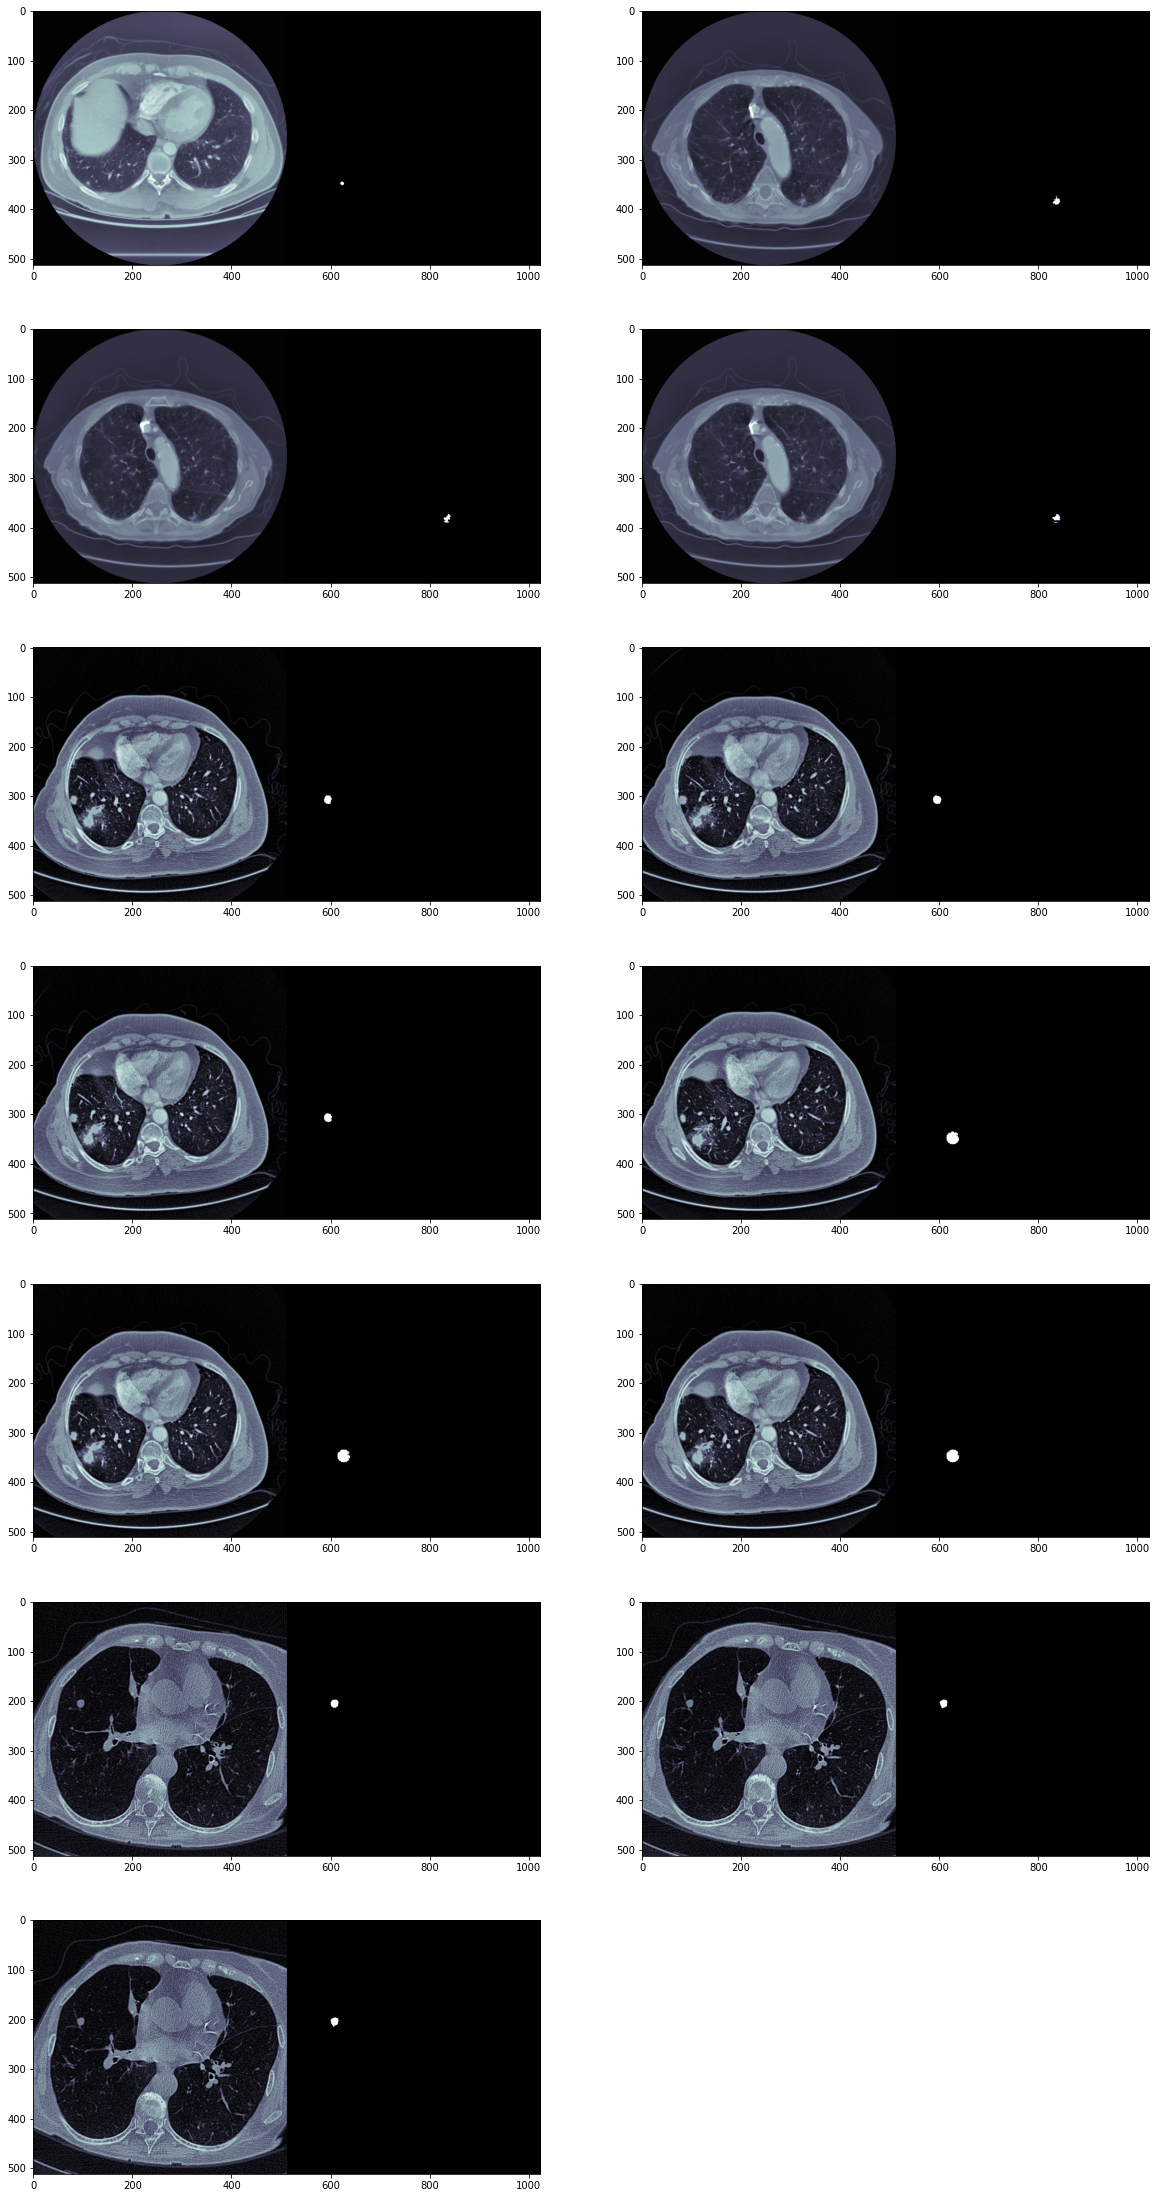

In [54]:
display_mask(imgs, masksi)